# Object Detection

In this assignment, you will implement a fruit detector. 
The task is divided into steps for simpler navigation.

Let's start!

In [1]:
# we will need this library to process the labeling
! pip install albumentations==0.4.6
! pip install xmltodict
! pip uninstall opencv-python-headless==4.5.5.62
! pip install opencv-python-headless==4.1.2.30

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 117 kB 30.3 MB/s 
     |████████████████████████████████| 948 kB 47.5 MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65174 sha256=a9d93992a055eb74ca4a52900750494bd646698173ffae736405f27323090061
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/sim

In [2]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import xmltodict
import json
import glob
import cv2
import os
import torchvision
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import fasterrcnn_resnet50_fpn

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from tqdm import tqdm

## Step 0. Dataset

First, let's load the data that you can download [here](https://drive.google.com/file/d/1Ve5e9qdy_sUCMM4qXWrw8ecURg2af9Cm/view?usp=sharing). 

We have already written a dataset class for you and we encourage you to figure out how it works.

In [3]:
class2tag = {"apple": 1, "orange": 2, "banana": 3}


class FruitDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.images = []
        self.annotations = []
        self.transform = transform
        for annotation in glob.glob(data_dir + "/*xml"):
            image_fname = os.path.splitext(annotation)[0] + ".jpg"
            self.images.append(cv2.cvtColor(cv2.imread(image_fname), cv2.COLOR_BGR2RGB))
            with open(annotation) as f:
                annotation_dict = xmltodict.parse(f.read())
            bboxes = []
            labels = []
            objects = annotation_dict["annotation"]["object"]
            if not isinstance(objects, list):
                objects = [objects]
            for obj in objects:
                bndbox = obj["bndbox"]
                bbox = [bndbox["xmin"], bndbox["ymin"], bndbox["xmax"], bndbox["ymax"]]
                bbox = list(map(int, bbox))
                bboxes.append(torch.tensor(bbox))
                labels.append(class2tag[obj["name"]])
            self.annotations.append(
                {"boxes": torch.stack(bboxes).float(), "labels": torch.tensor(labels)}
            )

    def __getitem__(self, i):
        if self.transform:
            # the following code is correct if you use albumentations
            # if you use torchvision transforms you have to modify it
            res = self.transform(
                image=self.images[i],
                bboxes=self.annotations[i]["boxes"],
                labels=self.annotations[i]["labels"],
            )
            return res["image"], {
                "boxes": torch.tensor(res["bboxes"]),
                "labels": torch.tensor(res["labels"]),
            }
        else:
            return self.images[i], self.annotations[i]

    def __len__(self):
        return len(self.images)

## Step 1. Intersection over Union (10 points)

In the [Object Detection task](https://en.wikipedia.org/wiki/Object_detection), you need to find objects of a certain class on the image and locate their positions (using the bounding box). The  model should predict the coordinates of the bounding box `[x0, y0, x1, y1]` and the label for this box. The model can predict multiple candidate bounding boxes for an object. We will select candidates using [Intersection Over Union](https://en.wikipedia.org/wiki/Jaccard_index).

<img src=https://upload.wikimedia.org/wikipedia/commons/c/c7/Intersection_over_Union_-_visual_equation.png>


Implement a function that will calculate IoU for bounding boxes.

In [4]:
def intersection_over_union(dt_bbox, gt_bbox):
    """
    Intersection over Union between two bboxes
    :param dt_bbox: list or numpy array of size (4,) [x0, y0, x1, y1]
    :param gt_bbox: list or numpy array of size (4,) [x0, y0, x1, y1]
    :return : intersection over union
    """
    ## YOUR CODE HERE
    i_x0 = max(dt_bbox[0], gt_bbox[0])
    i_y0 = max(dt_bbox[1], gt_bbox[1])
    i_x1 = min(dt_bbox[2], gt_bbox[2])
    i_y1 = min(dt_bbox[3], gt_bbox[3])

    h, w = i_x1 - i_x0, i_y1 - i_y0

    area_of_overlap = np.maximum(h*w, 0)

    area_dt = (dt_bbox[2] - dt_bbox[0])*(dt_bbox[3] - dt_bbox[1])
    area_gt = (gt_bbox[2] - gt_bbox[0])*(gt_bbox[3] - gt_bbox[1])

    area_of_union = area_dt + area_gt - area_of_overlap

    iou = area_of_overlap/area_of_union

    return iou

If the function is implemented correctly, then the execution of the following cell will produce:

**0.14285714285714285**

In [5]:
dt_bbox = [0, 0, 2, 2]
gt_bbox = [1, 1, 3, 3]
intersection_over_union(dt_bbox, gt_bbox)

0.14285714285714285

## Step 2. Evaluate Sample (15 points)

We now have to evaluate the predictions of the model. To do this, we will write a function that will do the following:
1. Take model predictions and ground truth bounding boxes and labels as inputs.
2. For each bounding box from the prediction, find the closest bounding box among the answers.
3. For each found pair of bounding boxes, check whether the IoU is greater than a certain threshold `iou_threshold`. If the **IoU** exceeds the threshold, then we consider this answer as **True Positive**.
4. Remove a matched bounding box from the evaluation.
5. For each predicted bounding box, return the detection score and whether we were able to match it or not.

In [6]:
import math

def evaluate_sample(target_pred, target_true, iou_threshold=0.5):
    # ground truth
    gt_bboxes = target_true['boxes'].numpy()
    gt_labels = target_true['labels'].numpy()

    # predictions
    dt_bboxes = target_pred['boxes'].numpy()
    dt_labels = target_pred['labels'].numpy()
    dt_scores = target_pred['scores'].numpy()

    results = []

    # for each bounding box from the prediction, find the closest bounding box among the answers

    for detection_id in range(len(dt_labels)):
        dt_bbox = dt_bboxes[detection_id, :]
        dt_label = dt_labels[detection_id]
        dt_score = dt_scores[detection_id]

        detection_result_dict = {'score': dt_score}

        ## YOUR CODE HERE

        ## Note that by design, 0 ≤ J(A, B) ≤ 1.0
        max_IoU = 0
        max_gt_id = -math.inf

        for gt_id in range(len(gt_labels)):
            gt_bbox = gt_bboxes[gt_id, :]
            gt_label = gt_labels[gt_id]

            _IoU = intersection_over_union(dt_bbox, gt_bbox)

            if _IoU > max_IoU and _IoU <= 1.0: 
                max_IoU = _IoU
                max_gt_id = gt_id
        
        if max_gt_id >= 0 and max_IoU >= iou_threshold:
            # mark as True Positive
            detection_result_dict['TP'] = 1
            # delete matched bounding box
            gt_labels = np.delete(gt_labels, max_gt_id, axis=0)
            gt_bboxes = np.delete(gt_bboxes, max_gt_id, axis=0)

        else:
            detection_result_dict['TP'] = 0

        results.append(detection_result_dict)

    return results

## Step 3. Evaluate Model (15 points)

To assess the quality of the model, we will use the [mAP](https://jonathan-hui.medium.com/\map-mean-average-precision-for-object-detection-45c121a31173) metric defined as AP Area under the curve. To do this, you will need to calculate `recall` and` precision`.

In [7]:
from sklearn.metrics import auc

In [8]:
def evaluate(model, test_loader, device):
    results = []
    model.eval()
    nbr_boxes = 0
    
    with torch.no_grad():
       
        for batch, (images, targets_true) in enumerate(test_loader):
            images = list(image.to(device).float() for image in images)
            targets_pred = model(images)
  

            targets_true = [{k: v.cpu().float() for k, v in t.items()} for t in targets_true]
            targets_pred = [{k: v.cpu().float() for k, v in t.items()} for t in targets_pred]

            for i in range(len(targets_true)) :
                target_true = targets_true[i]
                target_pred = targets_pred[i]
                nbr_boxes += target_true['labels'].shape[0]

                results.extend(evaluate_sample(target_pred, target_true))


    results = sorted(results, key=lambda k: k['score'], reverse=True)

    # compute precision and recall to calculate mAP

    ## YOUR CODE HERE
    cs_TP = np.cumsum([i["TP"] for i in results])
    cs_FP = np.cumsum([1-i["TP"] for i in results])
    precision = cs_TP / (cs_TP + cs_FP)
    recall = cs_TP / nbr_boxes


    return auc(recall, precision)

## Step 4. Train functions (30 points)

Now define the functions for training the model.

In [9]:
def train_one_epoch(model, train_dataloader, optimizer, device):
    model.train()
    train_loss = 0
    for images, targets in tqdm(train_dataloader, colour = 'green', leave=False):

        ### From previous part of def evaluate

        images = list(image.to(device).float() for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        ### The model FASTERRCNN_RESNET50_FPN returns a Dict[Tensor] during training,
        ### containing the classification and regression losses for both the RPN and the R-CNN

        optimizer.zero_grad()
        
        loss = sum(model(images, targets).values())

        ### common steps

        
        loss.backward()
        optimizer.step()
        
        ### accumulate losses

        train_loss += float(loss.cpu().detach().numpy())

    return train_loss


def train(model, train_dataloader, val_dataloader, optimizer, device, n_epochs=10):
    for epoch in range(n_epochs):
        print(f"Epoch: {epoch}")
        model.eval()
        test_auc = evaluate(model, val_dataloader, device=device)
        print("AUC ON TEST: {:.4f}".format(test_auc))
        model.train()
        train_one_epoch(model, train_dataloader, optimizer, device=device)

## Step 5. Train model (30 points)

Train the model for object detection on a training dataset and achieve a PR-AUC of at least 0.91 on a test dataset. You can use models from `torchvision`.

It is mandatory to use augmentation for training to achieve the desired result on the test. Use the `torchvision.transforms` module or the [albumentations](https://albumentations.ai/) library. The latter library is especially convenient since it can calculate the new coordinates of bounding boxes itself after image transformations. We advise you to pay attention to this [tutorial](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/). Please note that the code written in the dataset above is only correct if you are using `albumentations`.

In [10]:
model = fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 4)
model.to(device)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [13]:
from albumentations.augmentations.transforms import Normalize
train_transform = A.Compose([A.VerticalFlip(p=0.5),
                             A.HorizontalFlip(p=0.5), 
                             A.RandomBrightnessContrast(p=0.2),
                             Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                             ToTensorV2()
                             ], 
                             bbox_params=A.BboxParams(format='pascal_voc',
                                                      label_fields=['labels']))

val_transform = A.Compose([Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                           ToTensorV2()], 
                             bbox_params=A.BboxParams(format='pascal_voc',
                                                      label_fields=['labels'])) 

train_dataset = FruitDataset("./train_zip/train", transform=train_transform)
val_dataset = FruitDataset("./test_zip/test", transform=val_transform)

In [14]:
params = [i for i in model.parameters() if i.requires_grad]

optimizer = torch.optim.Adam(params
                            , lr=1e-05
                            )

collate_fn = lambda x:tuple(zip(*x)) 

train_dataloader = DataLoader(train_dataset
                              , batch_size=2
                              , shuffle=True
                              , num_workers=2
                              , collate_fn = collate_fn
                             )

val_dataloader = DataLoader(val_dataset
                            , batch_size=2
                            , num_workers=2
                            , collate_fn = collate_fn
                           )


Output the final quality of the model.

In [16]:
n_epochs = 5

train(model, train_dataloader, val_dataloader, optimizer, device, n_epochs)
evaluate(model, val_dataloader, device)

Epoch: 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

AUC ON TEST: 0.8567


Epoch: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

AUC ON TEST: 0.8675


Epoch: 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

AUC ON TEST: 0.8986


Epoch: 3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

AUC ON TEST: 0.9083


Epoch: 4


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

AUC ON TEST: 0.9052


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

0.9176349063153906

In [ ]:
import torchvision

Draw predicted bounding boxes for any two images from the test dataset.

In [50]:
image, labels = next(iter(val_dataset))
pred = model(image.unsqueeze(0).to(device))[0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [74]:
MEAN = torch.tensor([0.485, 0.456, 0.406])
STD = torch.tensor([0.229, 0.224, 0.225])

image = image * STD[:, None, None] + MEAN[:, None, None]

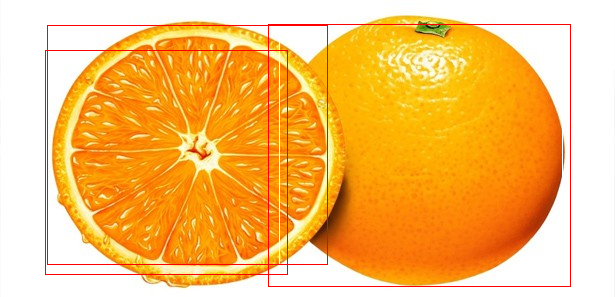

In [75]:
from PIL import ImageDraw

image = torchvision.transforms.ToPILImage()(image)
draw = ImageDraw.Draw(image)
for box in labels['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])])
    
for box in pred['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='red')
image